In [1]:
from pathlib import Path

thispath = Path('__file__').resolve()
base_path = thispath.parent.parent
import sys; sys.path.insert(0, str(base_path))
from dataset.copd_dataset import DirLabCOPD

In [2]:
from utils.metrics import target_registration_error
import elastix.elastix_utils as e_utils
from utils.utils import save_img_from_array_using_metadata, get_landmarks_array_from_txt_file
import SimpleITK as sitk
import pandas as pd
from tqdm import tqdm
import time
import numpy as np

def run_experiment(
    dataset, param_maps_to_use, output_path, params_path, mask=None, experiment_name=None
):
    results = {}
    for i in tqdm(range(len(dataset))):
        sample = dataset[i]
        # for pm in param_maps_to_use:
        # Define output paths
        pm = param_maps_to_use[-1]
        output_pm_path = output_path / pm.rstrip('.txt') / experiment_name
        output_pm_path.mkdir(exist_ok=True, parents=True)
        # Read and modify parameters file
        parameters_filename = params_path / pm 
        result_path = output_pm_path / sample['case']
        result_path.mkdir(exist_ok=True, parents=True)
        
        # field_value_pairs = [('WriteResultImage', 'true'), ('ResultImageFormat', 'nii.gz')]
        field_value_pairs = [
            ('WriteResultImage', 'true'),
            ('ResultImageFormat', 'nii.gz')
        ]
        e_utils.modify_field_parameter_map(field_value_pairs, parameters_filename)

        # Create temporary image files with the preprocessings included and 
        # also for the selected binary masks.
        res_path = result_path / 'res_tmp'
        res_path.mkdir(exist_ok=True, parents=True)

        param_maps_to_use_ = [str(params_path / p) for p in param_maps_to_use] 
        # Inhale
        i_temp_path = res_path / 'i_img.nii.gz'
        save_img_from_array_using_metadata(
            np.moveaxis(sample['i_img'], [0,1,2], [2,1,0]), sample['ref_metadata'], i_temp_path)
        i_body_mask_temp_path = res_path / 'i_body_mask_img.nii.gz'
        save_img_from_array_using_metadata(
            np.moveaxis(sample['i_body_mask'], [0,1,2], [2,1,0]), sample['ref_metadata'], i_body_mask_temp_path)
        i_lungs_mask_temp_path = res_path / 'i_lungs_mask_img.nii.gz'
        save_img_from_array_using_metadata(
            np.moveaxis(sample['i_lung_mask'], [0,1,2], [2,1,0]), sample['ref_metadata'], i_lungs_mask_temp_path)

        # Exhales
        e_temp_path = res_path / 'e_img.nii.gz'
        save_img_from_array_using_metadata(
            np.moveaxis(sample['e_img'], [0,1,2], [2,1,0]), sample['ref_metadata'], e_temp_path)
        e_body_mask_temp_path = res_path / 'e_body_mask_img.nii.gz'
        save_img_from_array_using_metadata(
            np.moveaxis(sample['e_body_mask'], [0,1,2], [2,1,0]), sample['ref_metadata'], e_body_mask_temp_path)
        e_lungs_mask_temp_path = res_path / 'e_lungs_mask_img.nii.gz'
        save_img_from_array_using_metadata(
            np.moveaxis(sample['e_lung_mask'], [0,1,2], [2,1,0]), sample['ref_metadata'], e_lungs_mask_temp_path)

        # Register
        print(f"Estimating transformation case {sample['case']}...")
        start = time.time()
        if mask is None:
            transform_map_path = e_utils.elastix_wrapper(
                i_temp_path, e_temp_path, res_path.parent, param_maps_to_use_,
                verbose=False, keep_just_useful_files=False
            )
        elif mask == 'body':
            transform_map_path = e_utils.elastix_wrapper(
                i_temp_path, e_temp_path, res_path.parent, param_maps_to_use_,
                i_body_mask_temp_path, e_body_mask_temp_path, verbose=False,
                keep_just_useful_files=False
            )
        else:
            transform_map_path = e_utils.elastix_wrapper(
                i_temp_path, e_temp_path, res_path.parent, param_maps_to_use_,
                i_lungs_mask_temp_path, e_lungs_mask_temp_path, verbose=False,
                keep_just_useful_files=False
            )
        reg_time = time.time()-start
        case_path = Path(sample['i_img_path']).parent
        
        name = f"{sample['case']}_300_iBH_xyz_r1.txt"
        lm_points_filepath = case_path / name
        # Correct transformation parameters file
        field_value_pairs = [
            ('ResultImageFormat', 'nii.gz'),
            ('ResultImagePixelType', "float"),
            ('FinalBSplineInterpolationorder', '0')
        ]
        e_utils.modify_field_parameter_map(field_value_pairs, transform_map_path)
        # Transform landmarks
        print('Transforming points...')
        lm_out_filepath = res_path.parent / f'r_{name}'
        e_utils.transformix_wrapper(
            lm_points_filepath, lm_out_filepath, transform_map_path,
            points=True, verbose=False, keep_just_useful_files=False)
        
        # Transform lung_masks
        print('Transforming lung mask...')
        full_mask_original_path = Path(sample['e_full_mask_path'])
        e_out_full_mask_temp_path = e_lungs_mask_temp_path.parent.parent / f'r_{full_mask_original_path.name}'
        e_utils.transformix_wrapper(
            full_mask_original_path, e_out_full_mask_temp_path, transform_map_path,
            points=False, verbose=False, keep_just_useful_files=False)

        # Get transformed landmarks positions
        landmarks = pd.read_csv(lm_out_filepath, header=None, sep='\t |\t', engine='python')
        landmarks.columns = ['point', 'idx', 'input_index', 'input_point', 'ouput_index', 'ouput_point', 'def']
        landmarks_input = [lm[-4:-1] for lm in np.asarray(landmarks.input_index.str.split(' '))]
        landmarks_input = np.asarray(landmarks_input).astype('int')

        landmarks = get_landmarks_array_from_txt_file(lm_out_filepath)
        
        # Get the TRE
        tre = target_registration_error(landmarks, sample['e_landmark_pts'], sample['ref_metadata']['spacing'])
        print(f'TRE estimated: {tre[0]}, {tre[1]}')
        print(f'Initial displacement GT: {sample["disp_mean"]}, {sample["disp_mean"]}')
        results[sample['case']] = {
            'mean_tre': tre[0],
            'std_tre': tre[1],
            'time': reg_time,
        }
    return results


In [3]:
def run_preproc_experiment(norm_cfg, clahe, hist_match, exp_name):
    data = DirLabCOPD(
        data_path=base_path/'data',
        cases=['all'],
        partitions=['train'],
        return_lm_mask=True,
        normalization_cfg=norm_cfg,
        return_body_masks=True,
        return_lung_masks=True,
        clahe=clahe,
        histogram_matching=hist_match
    )
    with open(results_path, 'r') as json_file:
        results = json.load(json_file)

    param_maps_to_use = [
        'Par0003.bs-R6-ug_8.txt'
    ]

    output_path = base_path / 'experiments/elastix'
    params_path = base_path / 'elastix/parameter_maps/OUR'

    # try:
    results[exp_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs', exp_name)
    # except:
    #     results[exp_name] = None

    with open(results_path, 'w') as json_file:
        json.dump(results, json_file, indent=4, separators=(',', ': '))


In [4]:
import json

base_path = Path().resolve().parent

results_path = base_path / 'experiments/elastix/results.json'
# results = {}

# with open(results_path, 'w') as json_file:
#     json.dump(results, json_file, indent=4, separators=(',', ': '))

In [2]:
NORMALIZATION_CFG = {
    'norm_type': 'min-max',
    'mask': None,
    'max_val': 255,
    'window': [-1024, 600],
    'dtype': 'uint8',
}

data = DirLabCOPD(
    data_path=base_path/'data',
    cases=['all'],
    partitions=['train'],
    return_lm_mask=True,
    normalization_cfg=None,
    return_body_masks=True,
    return_lung_masks=True
)

In [5]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Parameters.MI.Coarse.Bspline_tuned.txt',
    # 'Parameters.MI.Fine.Bspline_tuned.txt',
    # 'Parameters.MI.RP.Bspline_tuned.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0007'
experiment_name = 'P0007-Coarse-None-None'
results[experiment_name] = \
    run_experiment(data, param_maps_to_use, output_path, params_path, None, experiment_name)

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

Estimating transformation case copd1...
Transforming points...
Transforming lung mask...
TRE estimated: 8.8, 4.81
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...
Transforming lung mask...
TRE estimated: 13.15, 6.29
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...
Transforming lung mask...
TRE estimated: 4.91, 2.97
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...
Transforming lung mask...
TRE estimated: 9.86, 4.04
Initial displacement GT: 30.9, 30.9


In [21]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Parameters.MI.Coarse.Bspline_tuned.txt',
    'Parameters.MI.Fine.Bspline_tuned.txt',
    # 'Parameters.MI.RP.Bspline_tuned.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0007'
experiment_name = 'P0007-Coarse+Fine-None-None'

try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, None, experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...
Transforming points...


 25%|██▌       | 1/4 [01:55<05:46, 115.50s/it]

TRE estimated: 8.79, 4.82
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...


 50%|█████     | 2/4 [03:37<03:35, 107.75s/it]

TRE estimated: 13.15, 6.28
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...


 75%|███████▌  | 3/4 [05:33<01:51, 111.53s/it]

TRE estimated: 4.89, 2.98
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...


100%|██████████| 4/4 [07:31<00:00, 112.81s/it]

TRE estimated: 9.84, 4.06
Initial displacement GT: 30.9, 30.9


In [5]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Parameters.MI.Coarse.Bspline_tuned.txt',
    'Parameters.MI.Fine.Bspline_tuned.txt',
    'Parameters.MI.RP.Bspline_tuned.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0007'
experiment_name = 'P0007-Coarse+Fine+RP-None-None'

try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, None)
except:
    results[experiment_name] = None


with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...
Transforming points...


 25%|██▌       | 1/4 [03:36<10:49, 216.66s/it]

TRE estimated: 7.49, 5.16
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...


 50%|█████     | 2/4 [06:55<06:51, 205.91s/it]

TRE estimated: 14.15, 7.2
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...


 75%|███████▌  | 3/4 [10:35<03:32, 212.64s/it]

TRE estimated: 4.84, 3.0
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...


100%|██████████| 4/4 [14:19<00:00, 214.89s/it]

TRE estimated: 8.61, 3.72
Initial displacement GT: 30.9, 30.9


In [6]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Parameters.MI.Coarse.Bspline_tuned.txt',
    'Parameters.MI.Fine.Bspline_tuned.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0007'
experiment_name = 'P0007-Coarse+Fine-Body-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'body')
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...
Transforming points...


 25%|██▌       | 1/4 [01:51<05:34, 111.41s/it]

TRE estimated: 7.57, 5.42
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...


 50%|█████     | 2/4 [03:30<03:28, 104.39s/it]

TRE estimated: 11.86, 6.22
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...


 75%|███████▌  | 3/4 [05:24<01:48, 108.56s/it]

TRE estimated: 4.53, 2.83
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...


100%|██████████| 4/4 [07:21<00:00, 110.35s/it]

TRE estimated: 7.48, 3.78
Initial displacement GT: 30.9, 30.9


In [7]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Parameters.MI.Coarse.Bspline_tuned.txt',
    'Parameters.MI.Fine.Bspline_tuned.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0007'
experiment_name = 'P0007-Coarse+Fine-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs', experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...
Transforming points...


 25%|██▌       | 1/4 [01:56<05:50, 116.77s/it]

TRE estimated: 4.12, 3.45
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...


 50%|█████     | 2/4 [03:37<03:35, 107.51s/it]

TRE estimated: 6.61, 6.27
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...


 75%|███████▌  | 3/4 [05:38<01:53, 113.37s/it]

TRE estimated: 1.79, 1.42
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...


100%|██████████| 4/4 [07:33<00:00, 113.39s/it]

TRE estimated: 4.73, 3.15
Initial displacement GT: 30.9, 30.9


In [8]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = ['BSP.txt']
output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/BSP'
experiment_name = 'BSP-bsplines-None-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, None, experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...
Transforming points...


 25%|██▌       | 1/4 [04:11<12:33, 251.32s/it]

TRE estimated: 5.49, 5.14
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...


 50%|█████     | 2/4 [08:07<08:04, 242.18s/it]

TRE estimated: 9.7, 6.48
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...


 75%|███████▌  | 3/4 [12:40<04:16, 256.42s/it]

TRE estimated: 3.36, 3.32
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...


100%|██████████| 4/4 [17:13<00:00, 258.30s/it]

TRE estimated: 7.17, 4.97
Initial displacement GT: 30.9, 30.9


In [9]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = ['BSP.txt']
output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/BSP'
experiment_name = 'BSP-bsplines-Body-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'body', experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...
Transforming points...


 25%|██▌       | 1/4 [04:27<13:22, 267.42s/it]

TRE estimated: 3.24, 3.59
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...


 50%|█████     | 2/4 [08:40<08:38, 259.18s/it]

TRE estimated: 7.89, 6.79
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...


 75%|███████▌  | 3/4 [13:07<04:22, 262.52s/it]

TRE estimated: 2.76, 2.95
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...


100%|██████████| 4/4 [17:37<00:00, 264.34s/it]

TRE estimated: 6.79, 6.41
Initial displacement GT: 30.9, 30.9


In [6]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = ['BSP.txt']
output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/BSP'
experiment_name = 'BSP-bsplines-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs', experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

Estimating transformation case copd1...
Transforming points...
Transforming lung mask...
TRE estimated: 1.11, 1.05
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...
Transforming lung mask...
TRE estimated: 2.12, 2.62
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...
Transforming lung mask...
TRE estimated: 1.11, 1.0
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...
Transforming lung mask...
TRE estimated: 1.39, 1.11
Initial displacement GT: 30.9, 30.9


In [11]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Parameters.Par0008.affine.txt',
]
output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0008'
experiment_name = 'P0008-affine-None-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, None, experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...


  0%|          | 0/4 [00:18<?, ?it/s]


In [12]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Parameters.Par0008.affine.txt',
]
output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0008'
experiment_name = 'P0008-affine-Body-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'body', experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...


 25%|██▌       | 1/4 [00:33<01:40, 33.59s/it]

Transforming points...
TRE estimated: 12.3, 4.89
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...


 50%|█████     | 2/4 [01:02<01:01, 30.69s/it]

Transforming points...
TRE estimated: 16.88, 5.74
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...


 75%|███████▌  | 3/4 [01:36<00:32, 32.45s/it]

Transforming points...
TRE estimated: 5.38, 3.28
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...


100%|██████████| 4/4 [02:11<00:00, 32.80s/it]

Transforming points...
TRE estimated: 9.41, 3.73
Initial displacement GT: 30.9, 30.9


In [13]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Parameters.Par0008.affine.txt',
]
output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0008'
experiment_name = 'P0008-affine-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs', experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...


 25%|██▌       | 1/4 [00:37<01:51, 37.27s/it]

Transforming points...
TRE estimated: 9.23, 5.16
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...


 50%|█████     | 2/4 [01:06<01:04, 32.28s/it]

Transforming points...
TRE estimated: 10.82, 5.89
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...


 75%|███████▌  | 3/4 [01:42<00:34, 34.22s/it]

Transforming points...
TRE estimated: 3.46, 1.72
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...


 75%|███████▌  | 3/4 [02:05<00:41, 41.76s/it]


In [14]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Parameters.Par0008.affine.txt',
    'Parameters.Par0008.elastic.txt'
]
output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0008'
experiment_name = 'P0008-affine+elastic-None-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, None, experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...


  0%|          | 0/4 [00:18<?, ?it/s]


In [15]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Parameters.Par0008.affine.txt',
    'Parameters.Par0008.elastic.txt'
]
output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0008'
experiment_name = 'P0008-affine+elastic-Body-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'body', experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...
Transforming points...


 25%|██▌       | 1/4 [01:14<03:42, 74.18s/it]

TRE estimated: 9.85, 5.11
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...


 50%|█████     | 2/4 [02:20<02:19, 69.56s/it]

TRE estimated: 13.01, 7.01
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...


 75%|███████▌  | 3/4 [03:37<01:13, 73.08s/it]

TRE estimated: 3.6, 2.92
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...


100%|██████████| 4/4 [04:56<00:00, 74.11s/it]

TRE estimated: 6.99, 3.62
Initial displacement GT: 30.9, 30.9


In [16]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Parameters.Par0008.affine.txt',
    'Parameters.Par0008.elastic.txt'
]
output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0008'
experiment_name = 'P0008-affine+elastic-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs', experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...
Transforming points...


 25%|██▌       | 1/4 [01:22<04:07, 82.62s/it]

TRE estimated: 2.88, 3.06
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...


 50%|█████     | 2/4 [02:28<02:25, 72.65s/it]

TRE estimated: 6.88, 6.45
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...


 75%|███████▌  | 3/4 [03:49<01:16, 76.66s/it]

TRE estimated: 1.35, 1.17
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...


 75%|███████▌  | 3/4 [04:12<01:24, 84.09s/it]


In [17]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.affine.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0003'
experiment_name = 'P0003-affine-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs', experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...


 25%|██▌       | 1/4 [00:52<02:36, 52.08s/it]

Transforming points...
TRE estimated: 10.06, 5.64
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...


 50%|█████     | 2/4 [01:34<01:32, 46.27s/it]

Transforming points...
TRE estimated: 10.81, 5.92
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...


 75%|███████▌  | 3/4 [02:26<00:49, 49.17s/it]

Transforming points...
TRE estimated: 3.55, 1.73
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...


100%|██████████| 4/4 [03:18<00:00, 49.55s/it]

Transforming points...
TRE estimated: 7.48, 5.12
Initial displacement GT: 30.9, 30.9


In [18]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.affine.txt',
    'Par0003.bs-R1-fg.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0003'
experiment_name = 'P0003-affine+R1-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs', experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...


 25%|██▌       | 1/4 [01:24<04:14, 84.69s/it]

Transforming points...
TRE estimated: 9.48, 6.01
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...


 50%|█████     | 2/4 [02:34<02:32, 76.12s/it]

Transforming points...
TRE estimated: 9.54, 6.64
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...


 75%|███████▌  | 3/4 [04:01<01:21, 81.01s/it]

Transforming points...
TRE estimated: 1.53, 1.51
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...


100%|██████████| 4/4 [05:26<00:00, 81.55s/it]

Transforming points...
TRE estimated: 6.22, 5.58
Initial displacement GT: 30.9, 30.9


In [19]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.affine.txt',
    'Par0003.bs-R2-fg.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0003'
experiment_name = 'P0003-affine+R2-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs', experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...


 25%|██▌       | 1/4 [01:35<04:47, 95.97s/it]

Transforming points...
TRE estimated: 8.45, 6.54
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...


 50%|█████     | 2/4 [02:55<02:52, 86.23s/it]

Transforming points...
TRE estimated: 8.31, 6.96
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...


 75%|███████▌  | 3/4 [04:33<01:31, 91.46s/it]

Transforming points...
TRE estimated: 1.27, 1.09
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...


100%|██████████| 4/4 [06:07<00:00, 91.93s/it]

Transforming points...
TRE estimated: 5.2, 5.38
Initial displacement GT: 30.9, 30.9


In [20]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.affine.txt',
    'Par0003.bs-R4-fg.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0003'
experiment_name = 'P0003-affine+R4-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs', experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...


 25%|██▌       | 1/4 [01:56<05:50, 116.97s/it]

Transforming points...
TRE estimated: 6.06, 6.84
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...


 50%|█████     | 2/4 [03:35<03:32, 106.22s/it]

Transforming points...
TRE estimated: 7.3, 6.83
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...


 75%|███████▌  | 3/4 [05:36<01:52, 112.68s/it]

Transforming points...
TRE estimated: 1.36, 1.25
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...


100%|██████████| 4/4 [07:31<00:00, 112.86s/it]

Transforming points...
TRE estimated: 4.69, 5.01
Initial displacement GT: 30.9, 30.9


In [21]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.affine.txt',
    'Par0003.bs-R6-fg.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0003'
experiment_name = 'P0003-affine+R6-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs', experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...


 25%|██▌       | 1/4 [02:18<06:55, 138.63s/it]

Transforming points...
TRE estimated: 7.94, 6.99
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...


 50%|█████     | 2/4 [04:14<04:11, 125.53s/it]

Transforming points...
TRE estimated: 10.91, 8.79
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...


 75%|███████▌  | 3/4 [06:35<02:12, 132.20s/it]

Transforming points...
TRE estimated: 1.56, 1.67
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...


100%|██████████| 4/4 [08:49<00:00, 132.46s/it]

Transforming points...
TRE estimated: 9.52, 6.33
Initial displacement GT: 30.9, 30.9


In [22]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.affine.txt',
    'Par0003.bs-R8-fg.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0003'
experiment_name = 'P0003-affine+R8-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs', experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...


 25%|██▌       | 1/4 [02:45<08:15, 165.21s/it]

Transforming points...
TRE estimated: 7.75, 6.37
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...


 50%|█████     | 2/4 [04:59<04:53, 146.77s/it]

Transforming points...
TRE estimated: 11.16, 8.68
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...


 75%|███████▌  | 3/4 [07:46<02:36, 156.20s/it]

Transforming points...
TRE estimated: 1.77, 1.9
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...


100%|██████████| 4/4 [10:19<00:00, 154.89s/it]

Transforming points...
TRE estimated: 10.76, 6.31
Initial displacement GT: 30.9, 30.9


In [23]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.affine.txt',
    'Par0003.bs-R8-ug.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0003'
experiment_name = 'P0003-affine+R8ug-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs', experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...


 25%|██▌       | 1/4 [02:20<07:02, 140.75s/it]

Transforming points...
TRE estimated: 1.22, 1.11
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...


 25%|██▌       | 1/4 [03:15<09:45, 195.25s/it]


In [24]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.affine.txt',
    'Par0003.bs-R6-ug.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0003'
experiment_name = 'P0003-affine+R6ug-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs', experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...


 25%|██▌       | 1/4 [02:05<06:15, 125.03s/it]

Transforming points...
TRE estimated: 1.2, 1.18
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...


 50%|█████     | 2/4 [03:48<03:45, 112.58s/it]

Transforming points...
TRE estimated: 3.55, 4.54
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...


 75%|███████▌  | 3/4 [05:55<01:58, 118.85s/it]

Transforming points...
TRE estimated: 1.21, 0.99
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...


100%|██████████| 4/4 [07:58<00:00, 119.53s/it]

Transforming points...
TRE estimated: 1.64, 1.32
Initial displacement GT: 30.9, 30.9


In [25]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.affine.txt',
    'Par0003.bs-R4-ug.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0003'
experiment_name = 'P0003-affine+R4ug-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs', experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...


 25%|██▌       | 1/4 [01:49<05:29, 109.87s/it]

Transforming points...
TRE estimated: 1.21, 1.07
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...


 50%|█████     | 2/4 [03:23<03:20, 100.20s/it]

Transforming points...
TRE estimated: 3.29, 4.16
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...
TRE estimated: 1.17, 0.99
Initial displacement GT: 12.29, 12.29


 75%|███████▌  | 3/4 [05:14<01:45, 105.02s/it]

Estimating transformation case copd4...


100%|██████████| 4/4 [07:01<00:00, 105.38s/it]

Transforming points...
TRE estimated: 1.69, 1.56
Initial displacement GT: 30.9, 30.9


In [26]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.affine.txt',
    'Par0003.bs-R2-ug.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0003'
experiment_name = 'P0003-affine+R2ug-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs', experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...


 25%|██▌       | 1/4 [01:32<04:38, 92.78s/it]

Transforming points...
TRE estimated: 4.65, 6.16
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...


 50%|█████     | 2/4 [02:50<02:48, 84.09s/it]

Transforming points...
TRE estimated: 5.33, 6.44
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...


 75%|███████▌  | 3/4 [04:24<01:28, 88.71s/it]

TRE estimated: 1.22, 1.01
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...


100%|██████████| 4/4 [05:57<00:00, 89.43s/it]

Transforming points...
TRE estimated: 2.72, 3.57
Initial displacement GT: 30.9, 30.9


SECOND ROUND OF EXPERIMENTS

In [12]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.bs-R4-ug.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0003'
experiment_name = 'P0003-R4ug-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs', experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

Estimating transformation case copd1...
Transforming points...
Transforming lung mask...
TRE estimated: 1.31, 1.26
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...
Transforming lung mask...
TRE estimated: 2.81, 3.51
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...
Transforming lung mask...
TRE estimated: 1.19, 0.98
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...
Transforming lung mask...
TRE estimated: 1.61, 1.43
Initial displacement GT: 30.9, 30.9


    "P0003-affine+R4ug-Lungs-None": {
        "copd1": {
            "mean_tre": 1.21,
            "std_tre": 1.07,
            "time": 94.04643630981445
        },
        "copd2": {
            "mean_tre": 3.29,
            "std_tre": 4.16,
            "time": 80.12521958351135
        },
        "copd3": {
            "mean_tre": 1.17,
            "std_tre": 0.99,
            "time": 94.5142936706543
        },
        "copd4": {
            "mean_tre": 1.69,
            "std_tre": 1.56,
            "time": 91.17892789840698
        }
    },
    "P0003-R4ug-Lungs-None": {
        "copd1": {
            "mean_tre": 1.31,
            "std_tre": 1.26,
            "time": 68.47441744804382
        },
        "copd2": {
            "mean_tre": 2.81,
            "std_tre": 3.51,
            "time": 61.93882775306702
        },
        "copd3": {
            "mean_tre": 1.19,
            "std_tre": 0.98,
            "time": 70.07741189002991
        },
        "copd4": {
            "mean_tre": 1.61,
            "std_tre": 1.43,
            "time": 58.49851179122925
        }
    "BSP-bsplines-Lungs-None": {
        "copd1": {
            "mean_tre": 1.11,
            "std_tre": 1.05,
            "time": 272.60267758369446
        },
        "copd2": {
            "mean_tre": 2.12,
            "std_tre": 2.62,
            "time": 278.3260247707367
        },
        "copd3": {
            "mean_tre": 1.11,
            "std_tre": 1.0,
            "time": 296.4925916194916
        },
        "copd4": {
            "mean_tre": 1.39,
            "std_tre": 1.11,
            "time": 273.2813789844513
        }

In [17]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.bs-R6-ug.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0003'
experiment_name = 'P0003-R6ug-Lungs-None'
# try:
results[experiment_name] = \
    run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs', experiment_name)
# except:
#     results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

Estimating transformation case copd1...
Transforming points...
Transforming lung mask...
TRE estimated: 1.24, 1.21
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...
Transforming lung mask...
TRE estimated: 3.07, 3.93
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...
Transforming lung mask...
TRE estimated: 1.21, 1.0
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...
Transforming lung mask...
TRE estimated: 1.53, 1.17
Initial displacement GT: 30.9, 30.9


In [18]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.bs-R5-ug.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/Par0003'
experiment_name = 'P0003-R5ug-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs', experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

Estimating transformation case copd1...
Transforming points...
Transforming lung mask...
TRE estimated: 1.24, 1.15
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...
Transforming lung mask...
TRE estimated: 3.02, 4.0
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...
Transforming lung mask...
TRE estimated: 1.19, 1.0
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...
Transforming lung mask...
TRE estimated: 1.46, 1.14
Initial displacement GT: 30.9, 30.9


In [19]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.bs-R5-ug_pyramid.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/OUR'
experiment_name = 'OUR-P0003-R5ug-pyram-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs', experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

Estimating transformation case copd1...
Transforming points...
Transforming lung mask...
TRE estimated: 1.18, 1.04
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...
Transforming lung mask...
TRE estimated: 2.72, 3.3
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...
Transforming lung mask...
TRE estimated: 1.17, 0.98
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...
Transforming lung mask...
TRE estimated: 1.48, 1.16
Initial displacement GT: 30.9, 30.9


In [20]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.bs-R6-ug_pyramid.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/OUR'
experiment_name = 'OUR-P0003-pyram-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs', experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

Estimating transformation case copd1...
Transforming points...
Transforming lung mask...
TRE estimated: 1.16, 1.09
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...
Transforming lung mask...
TRE estimated: 2.73, 3.28
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...
Transforming lung mask...
TRE estimated: 1.19, 0.98
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...
Transforming lung mask...
TRE estimated: 1.45, 1.08
Initial displacement GT: 30.9, 30.9


In [21]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.bs-R6-ug_2.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/OUR'
experiment_name = 'OUR-P0003-Optim-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs', experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

Estimating transformation case copd1...
Transforming points...
Transforming lung mask...
TRE estimated: 1.2, 1.07
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...
Transforming lung mask...
TRE estimated: 2.54, 3.14
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...
Transforming lung mask...
TRE estimated: 1.18, 1.0
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...
Transforming lung mask...
TRE estimated: 1.52, 1.19
Initial displacement GT: 30.9, 30.9


In [5]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.bs-R6-ug_3.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/OUR'
experiment_name = 'OUR-P0003-Grid-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs', experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

Estimating transformation case copd1...
Transforming points...
Transforming lung mask...
TRE estimated: 1.47, 2.19
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...
Transforming lung mask...
TRE estimated: 1.91, 2.0
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...
Transforming lung mask...
TRE estimated: 1.11, 0.95
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...
Transforming lung mask...
TRE estimated: 14.22, 11.41
Initial displacement GT: 30.9, 30.9


In [6]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.bs-R6-ug_4.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/OUR'
experiment_name = 'OUR-P0003-Grid2-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs', experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

Estimating transformation case copd1...
Transforming points...
Transforming lung mask...
TRE estimated: 1.77, 2.92
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...
Transforming lung mask...
TRE estimated: 2.41, 3.03
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...
Transforming lung mask...
TRE estimated: 1.14, 0.96
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...
Transforming lung mask...
TRE estimated: 19.66, 11.06
Initial displacement GT: 30.9, 30.9


In [7]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.bs-R6-ug_6.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/OUR'
experiment_name = 'OUR-P0003-n_samples_1-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs', experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

Estimating transformation case copd1...
Transforming points...
Transforming lung mask...
TRE estimated: 1.14, 1.07
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...
Transforming lung mask...
TRE estimated: 2.32, 2.89
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...
Transforming lung mask...
TRE estimated: 1.17, 0.98
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...
Transforming lung mask...
TRE estimated: 1.44, 1.06
Initial displacement GT: 30.9, 30.9


In [8]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.bs-R6-ug_5.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/OUR'
experiment_name = 'OUR-P0003-n_samples_2-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs', experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

Estimating transformation case copd1...
Transforming points...
Transforming lung mask...
TRE estimated: 1.17, 1.04
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...
Transforming lung mask...
TRE estimated: 2.09, 2.4
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...
Transforming lung mask...
TRE estimated: 1.13, 0.99
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...
Transforming lung mask...
TRE estimated: 1.39, 1.03
Initial displacement GT: 30.9, 30.9


In [10]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.bs-R6-ug_7.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/OUR'
experiment_name = 'OUR-P0003-Recursive-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs', experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

Estimating transformation case copd1...
Transforming points...
Transforming lung mask...
TRE estimated: 1.19, 1.09
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...
Transforming lung mask...
TRE estimated: 2.18, 2.79
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...
Transforming lung mask...
TRE estimated: 1.16, 0.97
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...
Transforming lung mask...
TRE estimated: 1.39, 1.01
Initial displacement GT: 30.9, 30.9


In [11]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.bs-R6-ug_8.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/OUR'
experiment_name = 'OUR-P0003-SmoothMetric-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs', experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

Estimating transformation case copd1...
Transforming points...
Transforming lung mask...
TRE estimated: 1.15, 1.04
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...
Transforming lung mask...
TRE estimated: 2.21, 2.73
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...
Transforming lung mask...
TRE estimated: 1.14, 1.0
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...
Transforming lung mask...
TRE estimated: 1.37, 1.01
Initial displacement GT: 30.9, 30.9


In [12]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.bs-R6-ug_9.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/OUR'
experiment_name = 'OUR-P0003-RecursiveMetric-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs', experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

Estimating transformation case copd1...
Transforming points...
Transforming lung mask...
TRE estimated: 1.18, 1.04
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...
Transforming lung mask...
TRE estimated: 2.21, 2.75
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...
Transforming lung mask...
TRE estimated: 1.15, 0.98
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...
Transforming lung mask...
TRE estimated: 1.4, 1.05
Initial displacement GT: 30.9, 30.9


In [13]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

param_maps_to_use = [
    'Par0003.bs-R6-ug_10.txt'
]

output_path = base_path / 'experiments/elastix'
params_path = base_path / 'elastix/parameter_maps/OUR'
experiment_name = 'OUR-P0003-n_samples_3-Lungs-None'
try:
    results[experiment_name] = \
        run_experiment(data, param_maps_to_use, output_path, params_path, 'lungs', experiment_name)
except:
    results[experiment_name] = None

with open(results_path, 'w') as json_file:
    json.dump(results, json_file, indent=4, separators=(',', ': '))

Estimating transformation case copd1...
Transforming points...
Transforming lung mask...
TRE estimated: 1.17, 1.02
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...
Transforming lung mask...
TRE estimated: 2.08, 2.35
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...
Transforming lung mask...
TRE estimated: 1.15, 0.97
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...
Transforming lung mask...
TRE estimated: 1.41, 1.01
Initial displacement GT: 30.9, 30.9


THIRD ROUND

window

In [5]:
norm_cfg = {
    'norm_type': None,
    'mask': None,
    'max_val': 255,
    'window': [-1024, 600],
    'dtype': 'uint8',
}
experiment_name = 'OUR-P0003-8-Lungs-Window-None'
run_preproc_experiment(norm_cfg, clahe=False, hist_match=False, exp_name=experiment_name)

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...
Transforming points...
Transforming lung mask...


 25%|██▌       | 1/4 [06:47<20:22, 407.42s/it]

TRE estimated: 1.17, 1.09
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...
Transforming lung mask...


 50%|█████     | 2/4 [11:08<10:43, 321.52s/it]

TRE estimated: 3.23, 5.11
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...
Transforming lung mask...


 75%|███████▌  | 3/4 [16:00<05:07, 307.88s/it]

TRE estimated: 1.15, 0.99
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...
Transforming lung mask...


100%|██████████| 4/4 [20:41<00:00, 310.36s/it]

TRE estimated: 1.44, 1.09
Initial displacement GT: 30.9, 30.9


In [6]:
norm_cfg = {
    'norm_type': 'min-max',
    'mask': None,
    'max_val': 255,
    'window': [-1024, 600],
    'dtype': 'uint8',
}
experiment_name = 'OUR-P0003-8-Lungs-Window-MM'
run_preproc_experiment(norm_cfg, clahe=False, hist_match=False, exp_name=experiment_name)

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...
Transforming points...
Transforming lung mask...


 25%|██▌       | 1/4 [04:49<14:28, 289.41s/it]

TRE estimated: 1.19, 1.09
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...
Transforming lung mask...


 50%|█████     | 2/4 [09:10<09:05, 272.95s/it]

TRE estimated: 3.31, 5.22
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...
Transforming lung mask...


 75%|███████▌  | 3/4 [14:03<04:41, 281.90s/it]

TRE estimated: 1.15, 0.98
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...
Transforming lung mask...


100%|██████████| 4/4 [18:49<00:00, 282.39s/it]

TRE estimated: 1.45, 1.12
Initial displacement GT: 30.9, 30.9


In [7]:
norm_cfg = {
    'norm_type': 'min-max',
    'mask': 'lungs',
    'max_val': 255,
    'window': [-1024, 600],
    'dtype': 'uint8',
}
experiment_name = 'OUR-P0003-8-Lungs-Window-MML'
run_preproc_experiment(norm_cfg, clahe=False, hist_match=False, exp_name=experiment_name)

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...
Transforming points...
Transforming lung mask...


 25%|██▌       | 1/4 [05:06<15:20, 306.74s/it]

TRE estimated: 1.18, 1.1
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...
Transforming lung mask...


 50%|█████     | 2/4 [09:41<09:35, 287.74s/it]

TRE estimated: 3.21, 5.03
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...
Transforming lung mask...


 75%|███████▌  | 3/4 [14:46<04:55, 295.60s/it]

TRE estimated: 1.15, 1.0
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...
Transforming lung mask...


100%|██████████| 4/4 [19:21<00:00, 290.42s/it]

TRE estimated: 1.47, 1.13
Initial displacement GT: 30.9, 30.9


In [5]:
norm_cfg = {
    'norm_type': 'min-max',
    'mask': 'body',
    'max_val': 255,
    'window': [-1024, 600],
    'dtype': 'uint8',
}
experiment_name = 'OUR-P0003-8-Lungs-Window-MMB'
run_preproc_experiment(norm_cfg, clahe=False, hist_match=False, exp_name=experiment_name)

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...
Transforming points...
Transforming lung mask...


 25%|██▌       | 1/4 [05:14<15:43, 314.45s/it]

TRE estimated: 1.18, 1.1
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...
Transforming lung mask...


 50%|█████     | 2/4 [10:01<09:56, 298.47s/it]

TRE estimated: 3.21, 5.03
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...
Transforming lung mask...


 75%|███████▌  | 3/4 [15:19<05:07, 307.09s/it]

TRE estimated: 1.15, 1.0
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...
Transforming lung mask...


100%|██████████| 4/4 [19:32<00:00, 293.19s/it]

TRE estimated: 1.47, 1.13
Initial displacement GT: 30.9, 30.9


clahe

In [6]:
norm_cfg = {
    'norm_type': None,
    'mask': None,
    'max_val': 255,
    'window': None,
    'dtype': 'uint8',
}
experiment_name = 'OUR-P0003-8-Lungs-Clahe-None'
run_preproc_experiment(norm_cfg, clahe=True, hist_match=False, exp_name=experiment_name)

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...
Transforming points...
Transforming lung mask...


 25%|██▌       | 1/4 [08:09<24:28, 489.43s/it]

TRE estimated: 1.35, 1.7
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...
Transforming lung mask...


 50%|█████     | 2/4 [15:59<15:56, 478.12s/it]

TRE estimated: 3.3, 5.18
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...
Transforming lung mask...


 75%|███████▌  | 3/4 [24:28<08:12, 492.11s/it]

TRE estimated: 1.1, 0.96
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...
Transforming lung mask...


100%|██████████| 4/4 [31:09<00:00, 467.36s/it]

TRE estimated: 11.54, 18.43
Initial displacement GT: 30.9, 30.9


In [7]:
norm_cfg = {
    'norm_type': 'min-max',
    'mask': None,
    'max_val': 255,
    'window': None,
    'dtype': 'uint8',
}
experiment_name = 'OUR-P0003-8-Lungs-Clahe-MM'
run_preproc_experiment(norm_cfg, clahe=True, hist_match=False, exp_name=experiment_name)

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...
Transforming points...
Transforming lung mask...


 25%|██▌       | 1/4 [05:06<15:20, 306.98s/it]

TRE estimated: 1.26, 1.31
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...
Transforming lung mask...


 50%|█████     | 2/4 [09:56<09:53, 296.72s/it]

TRE estimated: 3.44, 5.41
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...
Transforming lung mask...


 75%|███████▌  | 3/4 [15:14<05:06, 306.32s/it]

TRE estimated: 1.09, 0.96
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...
Transforming lung mask...


100%|██████████| 4/4 [20:30<00:00, 307.57s/it]

TRE estimated: 8.6, 16.94
Initial displacement GT: 30.9, 30.9


In [8]:
norm_cfg = {
    'norm_type': 'min-max',
    'mask': 'lungs',
    'max_val': 255,
    'window': None,
    'dtype': 'uint8',
}
experiment_name = 'OUR-P0003-8-Lungs-Clahe-MML'
run_preproc_experiment(norm_cfg, clahe=True, hist_match=False, exp_name=experiment_name)

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...
Transforming points...
Transforming lung mask...


 25%|██▌       | 1/4 [05:07<15:21, 307.18s/it]

TRE estimated: 1.27, 1.61
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...
Transforming lung mask...


 50%|█████     | 2/4 [10:29<10:32, 316.04s/it]

TRE estimated: 3.31, 5.28
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...
Transforming lung mask...


 75%|███████▌  | 3/4 [16:48<05:44, 344.90s/it]

TRE estimated: 1.11, 0.97
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...
Transforming lung mask...


100%|██████████| 4/4 [22:28<00:00, 337.16s/it]

TRE estimated: 9.32, 17.16
Initial displacement GT: 30.9, 30.9


In [9]:
norm_cfg = {
    'norm_type': 'min-max',
    'mask': 'body',
    'max_val': 255,
    'window': None,
    'dtype': 'uint8',
}
experiment_name = 'OUR-P0003-8-Body-Clahe-MMB'
run_preproc_experiment(norm_cfg, clahe=True, hist_match=False, exp_name=experiment_name)

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...
Transforming points...
Transforming lung mask...


 25%|██▌       | 1/4 [05:11<15:33, 311.04s/it]

TRE estimated: 1.3, 1.6
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...
Transforming lung mask...


 50%|█████     | 2/4 [10:20<10:19, 309.92s/it]

TRE estimated: 3.39, 5.42
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...
Transforming lung mask...


 75%|███████▌  | 3/4 [15:51<05:19, 319.78s/it]

TRE estimated: 1.11, 0.96
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...
Transforming lung mask...


100%|██████████| 4/4 [21:08<00:00, 317.06s/it]

TRE estimated: 10.02, 17.75
Initial displacement GT: 30.9, 30.9


Nothing

In [10]:
norm_cfg = {
    'norm_type': None,
    'mask': None,
    'max_val': 255,
    'window': None,
    'dtype': 'uint8',
}
experiment_name = 'OUR-P0003-8-Lungs-Nth-None'
run_preproc_experiment(norm_cfg, clahe=False, hist_match=False, exp_name=experiment_name)

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...
Transforming points...
Transforming lung mask...


 25%|██▌       | 1/4 [04:34<13:43, 274.48s/it]

TRE estimated: 1.15, 1.04
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...
Transforming lung mask...


 50%|█████     | 2/4 [08:45<08:41, 260.56s/it]

TRE estimated: 2.21, 2.73
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...
Transforming lung mask...


 75%|███████▌  | 3/4 [13:34<04:33, 273.58s/it]

TRE estimated: 1.14, 1.0
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...
Transforming lung mask...


100%|██████████| 4/4 [18:09<00:00, 272.49s/it]

TRE estimated: 1.37, 1.01
Initial displacement GT: 30.9, 30.9


In [11]:
norm_cfg = {
    'norm_type': 'min-max',
    'mask': None,
    'max_val': 255,
    'window': None,
    'dtype': 'uint8',
}
experiment_name = 'OUR-P0003-8-Lungs-Nth-MM'
run_preproc_experiment(norm_cfg, clahe=False, hist_match=False, exp_name=experiment_name)

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...
Transforming points...
Transforming lung mask...


 25%|██▌       | 1/4 [04:38<13:54, 278.23s/it]

TRE estimated: 1.16, 1.08
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...
Transforming lung mask...


 50%|█████     | 2/4 [08:50<08:46, 263.17s/it]

TRE estimated: 2.22, 2.89
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...
Transforming lung mask...


 75%|███████▌  | 3/4 [14:03<04:45, 285.66s/it]

TRE estimated: 1.16, 0.99
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...
Transforming lung mask...


100%|██████████| 4/4 [19:25<00:00, 291.30s/it]

TRE estimated: 1.39, 1.01
Initial displacement GT: 30.9, 30.9


In [12]:
norm_cfg = {
    'norm_type': 'min-max',
    'mask': 'lungs',
    'max_val': 255,
    'window': None,
    'dtype': 'uint8',
}
experiment_name = 'OUR-P0003-8-Lungs-Nth-MML'
run_preproc_experiment(norm_cfg, clahe=False, hist_match=False, exp_name=experiment_name)

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...
Transforming points...
Transforming lung mask...


 25%|██▌       | 1/4 [05:05<15:17, 305.76s/it]

TRE estimated: 1.16, 1.05
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...
Transforming lung mask...


 50%|█████     | 2/4 [09:29<09:22, 281.12s/it]

TRE estimated: 2.25, 2.82
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...
Transforming lung mask...


 75%|███████▌  | 3/4 [14:26<04:48, 288.32s/it]

TRE estimated: 1.14, 1.0
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...
Transforming lung mask...


100%|██████████| 4/4 [18:50<00:00, 282.65s/it]

TRE estimated: 1.39, 1.03
Initial displacement GT: 30.9, 30.9


In [13]:
norm_cfg = {
    'norm_type': 'min-max',
    'mask': 'body',
    'max_val': 255,
    'window': None,
    'dtype': 'uint8',
}
experiment_name = 'OUR-P0003-8-Body-Nth-MMB'
run_preproc_experiment(norm_cfg, clahe=False, hist_match=False, exp_name=experiment_name)

  0%|          | 0/4 [00:00<?, ?it/s]

Estimating transformation case copd1...
Transforming points...
Transforming lung mask...


 25%|██▌       | 1/4 [04:37<13:53, 277.83s/it]

TRE estimated: 1.16, 1.09
Initial displacement GT: 25.9, 25.9
Estimating transformation case copd2...
Transforming points...
Transforming lung mask...


 50%|█████     | 2/4 [08:46<08:41, 260.90s/it]

TRE estimated: 2.19, 2.75
Initial displacement GT: 21.77, 21.77
Estimating transformation case copd3...
Transforming points...
Transforming lung mask...


 75%|███████▌  | 3/4 [13:24<04:28, 268.68s/it]

TRE estimated: 1.16, 1.0
Initial displacement GT: 12.29, 12.29
Estimating transformation case copd4...
Transforming points...
Transforming lung mask...


100%|██████████| 4/4 [17:59<00:00, 269.77s/it]

TRE estimated: 1.38, 1.02
Initial displacement GT: 30.9, 30.9


In [14]:
with open(results_path, 'r') as json_file:
    results = json.load(json_file)

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
df = []
for exp_name in results.keys():
    if results[exp_name] is None:
        row = [None, None, None, None, None]
    else:
        for case in results[exp_name].keys():
            columns = ['exp_name'] + list(results[exp_name][case].keys()) + ['case']
            row = [exp_name] + list(results[exp_name][case].values()) + [case]
            df.append(row)
df = pd.DataFrame(df, columns=columns)
df

,exp_name,mean_tre,std_tre,time,case
0,P0007-Coarse-None-None,8.80,4.81,40.899614,copd1
1,P0007-Coarse-None-None,13.15,6.29,38.984830,copd2
2,P0007-Coarse-None-None,4.91,2.97,42.730338,copd3
3,P0007-Coarse-None-None,9.86,4.04,45.719937,copd4
4,P0007-Coarse+Fine-None-None,8.79,4.82,93.952092,copd1
...,...,...,...,...,...
171,OUR-P0003-8-Lungs-Nth-MML,1.39,1.03,227.180979,copd4
172,OUR-P0003-8-Body-Nth-MMB,1.16,1.09,240.205580,copd1
173,OUR-P0003-8-Body-Nth-MMB,2.19,2.75,217.152526,copd2
174,OUR-P0003-8-Body-Nth-MMB,1.16,1.00,237.835988,copd3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


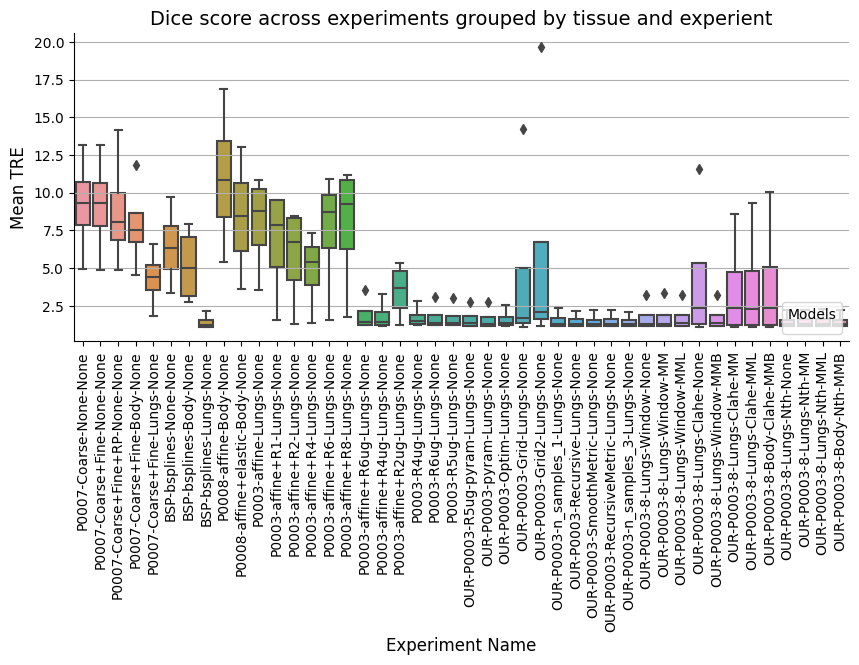

In [17]:
plt.figure(figsize=(10, 4))
plt.title('Dice score across experiments grouped by tissue and experient', fontsize=14)
sns.boxplot(data=df, x="exp_name", y="mean_tre")
sns.despine()
plt.grid(axis='y')
plt.xlabel('Experiment Name', fontsize=12)
plt.xticks(rotation=90)
plt.ylabel('Mean TRE', fontsize=12)
plt.legend(loc='lower right', title='Models', fontsize=10)
plt.pause(0.01)

In [18]:
[i for i in df.exp_name.unique() if ('OUR' in i) or ('Nth' in i)]

['OUR-P0003-R5ug-pyram-Lungs-None',
 'OUR-P0003-pyram-Lungs-None',
 'OUR-P0003-Optim-Lungs-None',
 'OUR-P0003-Grid-Lungs-None',
 'OUR-P0003-Grid2-Lungs-None',
 'OUR-P0003-n_samples_1-Lungs-None',
 'OUR-P0003-Recursive-Lungs-None',
 'OUR-P0003-SmoothMetric-Lungs-None',
 'OUR-P0003-RecursiveMetric-Lungs-None',
 'OUR-P0003-n_samples_3-Lungs-None',
 'OUR-P0003-8-Lungs-Window-None',
 'OUR-P0003-8-Lungs-Window-MM',
 'OUR-P0003-8-Lungs-Window-MML',
 'OUR-P0003-8-Lungs-Clahe-None',
 'OUR-P0003-8-Lungs-Window-MMB',
 'OUR-P0003-8-Lungs-Clahe-MM',
 'OUR-P0003-8-Lungs-Clahe-MML',
 'OUR-P0003-8-Body-Clahe-MMB',
 'OUR-P0003-8-Lungs-Nth-None',
 'OUR-P0003-8-Lungs-Nth-MM',
 'OUR-P0003-8-Lungs-Nth-MML',
 'OUR-P0003-8-Body-Nth-MMB']

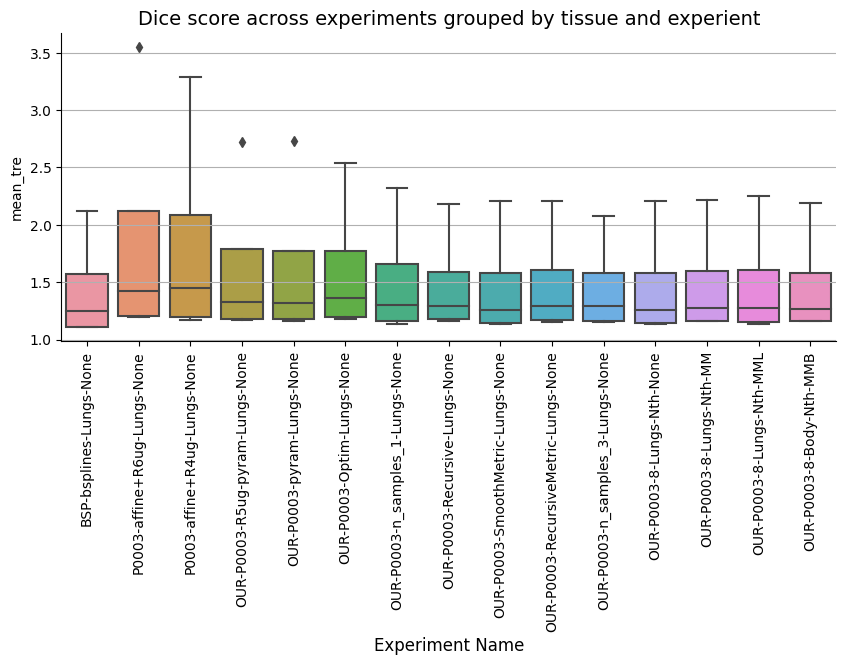

In [19]:
df_temp = df.loc[df.exp_name.isin([
    'BSP-bsplines-Lungs-None', 'P0003-affine+R6ug-Lungs-None', 'P0003-affine+R4ug-Lungs-None', 'OUR-P0003-R5ug-pyram-Lungs-None',
    'OUR-P0003-pyram-Lungs-None', 'OUR-P0003-Optim-Lungs-None', 'OUR-P0003-n_samples_1-Lungs-None',
    'OUR-P0003-Recursive-Lungs-None', 'OUR-P0003-SmoothMetric-Lungs-None', 'OUR-P0003-RecursiveMetric-Lungs-None',
    'OUR-P0003-n_samples_3-Lungs-None', 'OUR-P0003-8-Lungs-Nth-None', 'OUR-P0003-8-Lungs-Nth-MM',
    'OUR-P0003-8-Lungs-Nth-MML', 'OUR-P0003-8-Body-Nth-MMB'
    ])]
plt.figure(figsize=(10, 4))
plt.title('Dice score across experiments grouped by tissue and experient', fontsize=14)
sns.boxplot(data=df_temp, x="exp_name", y="mean_tre")
sns.despine()
plt.grid(axis='y')
plt.xlabel('Experiment Name', fontsize=12)
plt.xticks(rotation=90)
# plt.ylabel('Mean TRE', fontsize=12)
# plt.legend(loc='lower right', title='Models', fontsize=10)
plt.pause(0.01)
# plt.xticks(rotation=90)

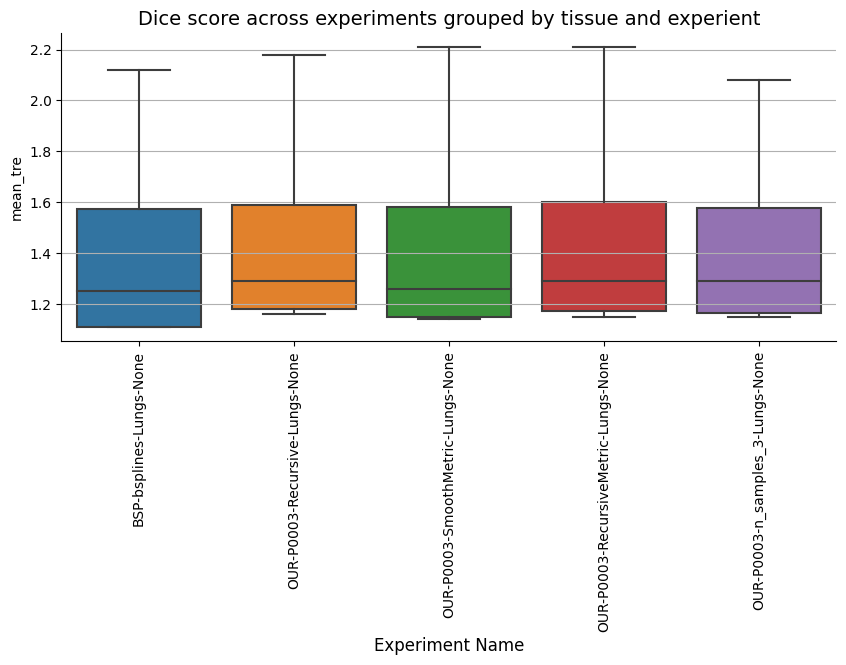

In [21]:
df_temp = df.loc[df.exp_name.isin([
    'BSP-bsplines-Lungs-None', 'OUR-P0003-Recursive-Lungs-None', 'OUR-P0003-SmoothMetric-Lungs-None',
    'OUR-P0003-RecursiveMetric-Lungs-None', 'OUR-P0003-n_samples_3-Lungs-None'
    ])]
plt.figure(figsize=(10, 4))
plt.title('Dice score across experiments grouped by tissue and experient', fontsize=14)
sns.boxplot(data=df_temp, x="exp_name", y="mean_tre")
sns.despine()
plt.grid(axis='y')
plt.xlabel('Experiment Name', fontsize=12)
plt.xticks(rotation=90)
# plt.ylabel('Mean TRE', fontsize=12)
# plt.legend(loc='lower right', title='Models', fontsize=10)
plt.pause(0.01)
# plt.xticks(rotation=90)

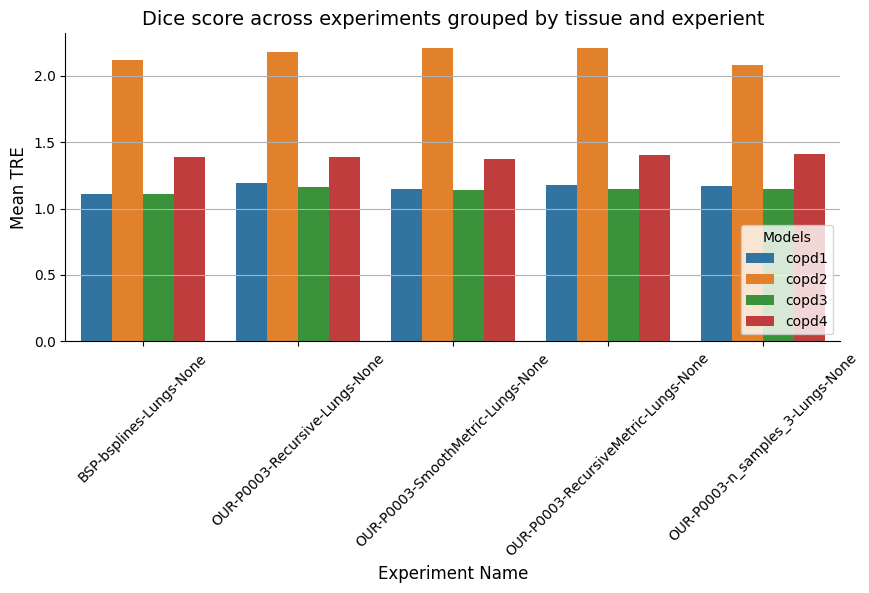

In [29]:
df_temp = df.loc[df.exp_name.isin([
    'BSP-bsplines-Lungs-None', 'OUR-P0003-Recursive-Lungs-None', 'OUR-P0003-SmoothMetric-Lungs-None', 'OUR-P0003-RecursiveMetric-Lungs-None', 'OUR-P0003-n_samples_3-Lungs-None'
    ])]
plt.figure(figsize=(10, 4))
plt.title('Dice score across experiments grouped by tissue and experient', fontsize=14)
sns.barplot(data=df_temp, x="exp_name", y="mean_tre", hue='case')
sns.despine()
plt.grid(axis='y')
plt.xlabel('Experiment Name', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('Mean TRE', fontsize=12)
plt.legend(loc='lower right', title='Models', fontsize=10)
plt.pause(0.01)

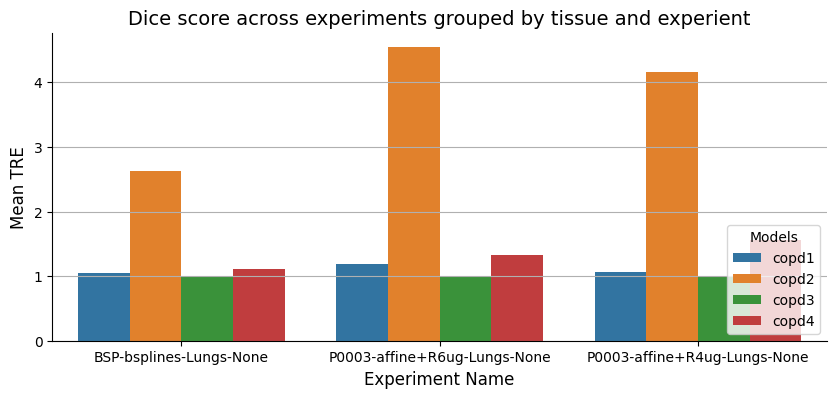

In [17]:
df_temp = df.loc[df.exp_name.isin(['BSP-bsplines-Lungs-None', 'P0003-affine+R6ug-Lungs-None', 'P0003-affine+R4ug-Lungs-None'])]
plt.figure(figsize=(10, 4))
plt.title('Dice score across experiments grouped by tissue and experient', fontsize=14)
sns.barplot(data=df_temp, x="exp_name", y="std_tre", hue='case')
sns.despine()
plt.grid(axis='y')
plt.xlabel('Experiment Name', fontsize=12)
# plt.xticks(rotation=90)
plt.ylabel('Mean TRE', fontsize=12)
plt.legend(loc='lower right', title='Models', fontsize=10)
plt.pause(0.01)

In [24]:
landmarks = get_landmarks_array_from_txt_file(Path('/home/jseia/Desktop/MAIA/classes/spain/mira/final_project/marwan_data_anwai_results/copd2/copd2_300_iBH_xyz_r1.txt'))
landmarks = pd.DataFrame(landmarks)
landmarks.to_csv(
    '/home/jseia/Desktop/MAIA/classes/spain/mira/final_project/marwan_data_anwai_results/copd2/copd2_300_iBH_xyz_r1_.txt',
    index=False,
    header=False
)

In [25]:
landmarks = get_landmarks_array_from_txt_file(Path('/home/jseia/Desktop/MAIA/classes/spain/mira/final_project/marwan_data_anwai_results/copd3/copd3_300_iBH_xyz_r1.txt'))
landmarks = pd.DataFrame(landmarks)
landmarks.to_csv(
    '/home/jseia/Desktop/MAIA/classes/spain/mira/final_project/marwan_data_anwai_results/copd3/copd3_300_iBH_xyz_r1_.txt',
    index=False,
    header=False
)

In [26]:
landmarks = get_landmarks_array_from_txt_file(Path('/home/jseia/Desktop/MAIA/classes/spain/mira/final_project/marwan_data_anwai_results/copd4/copd4_300_iBH_xyz_r1.txt'))
landmarks = pd.DataFrame(landmarks)
landmarks.to_csv(
    '/home/jseia/Desktop/MAIA/classes/spain/mira/final_project/marwan_data_anwai_results/copd4/copd4_300_iBH_xyz_r1_.txt',
    index=False,
    header=False
)